> 데이터 불러오기

> 데이터 확인

> train, test 데이터 나누기

> 계층적 샘플링

> 데이터 시각화

> 상관관계 조사

> 특성 조합

> 데이터 전처리

> 모델 선택

> 하이퍼파라미터 설정

> 테스트 세트 평가

> 신뢰 구간

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. 데이터 불러오기
import os
import pandas as pd

os.chdir("/content/drive/MyDrive/machine_learning/titanic")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

- PassengerId : 고유 번호 (X)
- Survived : 생존 여부
- Pclass : 승선권 클래스
- Name : 이름 (X)
- Sex : 성별
- Age : 나이
- SibSp : 동반한 형제자매와 배우자 수
- Parch : 동반한 부모와 자식 수
- Ticket : 티켓 고유 넘버 (X)
- Fare : 티켓 요금
- Cabin : 객실 번호
- Embarked : 승선한 항

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

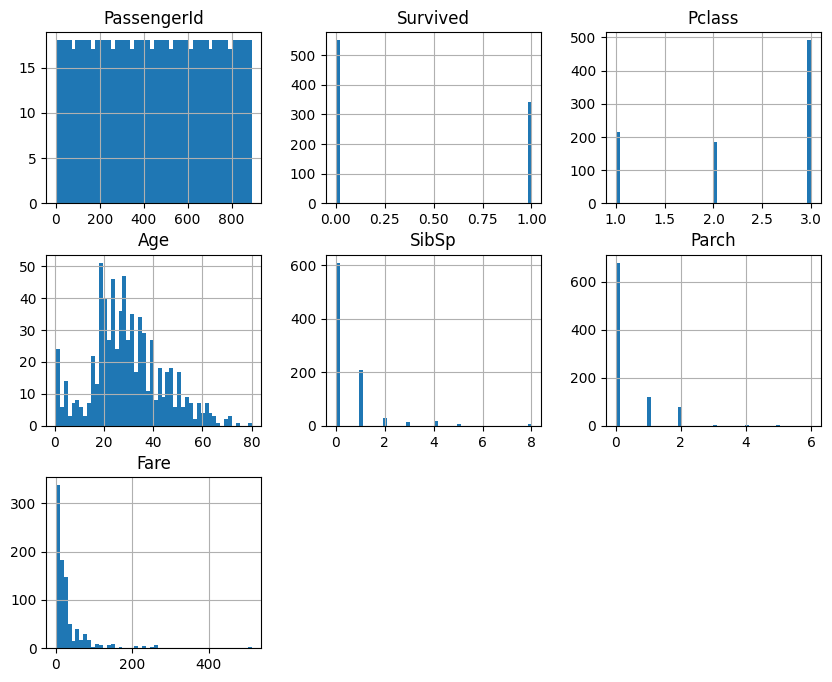

In [3]:
# 2. 데이터 확인
# 텍스트형 : Name, Sex, Ticket, Cabin, Embarked 확인
# 결측치 : Age(714), Cabin(204), Embarked(889) 확인
# Age 범주화 필요
# 범주화된 Age, Fare 스케일링 필요
import matplotlib.pyplot as plt

print(train.info())
train.hist(bins=50, figsize=(10, 8))

In [4]:
# 3. 계층적 샘플링
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

train_set = train.drop(["Name", "Ticket", "Cabin"], axis=1)

train_set["Age"] = train_set["Age"].fillna(train["Age"].mean())
train_set["Age_cat"] = pd.cut(train_set["Age"], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, np.inf], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_set, train_set["Age_cat"]):
  strat_train = train_set.loc[train_index]
  strat_test = train_set.loc[test_index]

for set_ in (strat_train, strat_test):
  set_.drop("Age_cat", axis=1, inplace=True)

In [5]:
# 4. 상관관계
from pandas.plotting import scatter_matrix

matrix_corr = strat_train.corr()
matrix_corr["Survived"].sort_values(ascending=False)

<ipython-input-5-74af8057b456>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr = strat_train.corr()


Survived       1.000000
Fare           0.256567
Parch          0.093310
PassengerId   -0.001171
Age           -0.054245
SibSp         -0.054452
Pclass        -0.352065
Name: Survived, dtype: float64

In [6]:
# 5. 데이터 전처리
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

train_set = strat_train.drop("Survived", axis=1)
train_labels = strat_train["Survived"].copy()

train_num = train_set.drop(["Sex", "Embarked"], axis=1)
train_sex = train_set[["Sex"]].copy()
train_emb = train_set[["Embarked"]].copy()

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])
train_num_set = num_pipeline.fit_transform(train_num)

emb_pipeline = Pipeline([
    ('encode', OrdinalEncoder()),
    ('impute', SimpleImputer(strategy="mean")),
])
train_emb_set = emb_pipeline.fit_transform(train_emb)

num_attribs = list(train_num)
sex_attribs = ["Sex"]
emb_attribs = ["Embarked"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('sex', OrdinalEncoder(), sex_attribs),
    ('emb', emb_pipeline, emb_attribs),
])

train_prepared = full_pipeline.fit_transform(train_set)
train_df = pd.DataFrame(train_prepared, columns=train_set.columns)

In [11]:
# 6. 모델 선택
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(train_prepared, train_labels)
sgd_pred = sgd_clf.predict(train_prepared)
sgd_f1 = f1_score(train_labels, sgd_pred)
sgd_score = cross_val_score(sgd_clf, train_prepared, train_labels, cv=3, scoring="accuracy")

# DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(train_prepared, train_labels)
tree_pred = tree_clf.predict(train_prepared)
tree_f1 = f1_score(train_labels, tree_pred)
tree_score = cross_val_score(tree_clf, train_prepared, train_labels, cv=3, scoring="accuracy")

# SVC
sv_clf = SVC()
sv_clf.fit(train_prepared, train_labels)
sv_pred = sv_clf.predict(train_prepared)
sv_f1 = f1_score(train_labels, sv_pred)
sv_score = cross_val_score(sv_clf, train_prepared, train_labels, cv=3, scoring="accuracy")

# RandomForestClassifier
forest_clf = RandomForestClassifier()
forest_clf.fit(train_prepared, train_labels)
forest_pred = forest_clf.predict(train_prepared)
forest_f1 = f1_score(train_labels, forest_pred)
forest_score = cross_val_score(forest_clf, train_prepared, train_labels, cv=3, scoring="accuracy")

print("sgd : ", sgd_score, sgd_f1)
print("tree : ", tree_score, tree_f1)
print("svc : ", sv_score, sv_f1)
print("forset : ", forest_score, forest_f1)

sgd :  [0.78151261 0.74261603 0.78059072] 0.7411545623836127
tree :  [0.79831933 0.78059072 0.75105485] 1.0
svc :  [0.8487395  0.83122363 0.78481013] 0.7813084112149533
forset :  [0.85294118 0.82278481 0.79324895] 1.0


In [34]:
# 7. 그리드 탐색
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1, 10], 'gamma' : [1, 0.1, 0.01], 'kernel' : ['linear', 'rbf']}

cv_clf = SVC()
grid_search = GridSearchCV(cv_clf, param_grid, cv=5, scoring="accuracy", return_train_score=True)
grid_search.fit(train_prepared, train_labels)

cvres = grid_search.cv_results_
for accuracy_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(accuracy_score, params)

0.7892248596473949 {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.7837092484979808 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.7892248596473949 {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
0.8215502807052104 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.7892248596473949 {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
0.8032798187727765 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.7892248596473949 {'C': 10, 'gamma': 1, 'kernel': 'linear'}
0.7795429922190485 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.7892248596473949 {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
0.8117108243868808 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.7892248596473949 {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
0.8131192750911062 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [36]:
# 7. 그리드 탐색
param_grid = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2, 4, 6, 8]},
    {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2, 4, 6]}
]

forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(train_prepared, train_labels)

cvres = grid_search.cv_results_
for accuracy_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(accuracy_score, params)

0.7626020872484015 {'max_features': 2, 'n_estimators': 3}
0.8019123261118795 {'max_features': 2, 'n_estimators': 10}
0.8173657648713494 {'max_features': 2, 'n_estimators': 30}
0.7921379522273044 {'max_features': 4, 'n_estimators': 3}
0.818825420463544 {'max_features': 4, 'n_estimators': 10}
0.8145823730336016 {'max_features': 4, 'n_estimators': 30}
0.7878889952605515 {'max_features': 6, 'n_estimators': 3}
0.8131759032727016 {'max_features': 6, 'n_estimators': 10}
0.8174071316290229 {'max_features': 6, 'n_estimators': 30}
0.7711000011819072 {'max_features': 8, 'n_estimators': 3}
0.793526693377773 {'max_features': 8, 'n_estimators': 10}
0.8089742226004325 {'max_features': 8, 'n_estimators': 30}
0.7724000992802185 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.8173775839449705 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.7864766159628408 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
0.8075500242291009 {'bootstrap': False, 'max_features': 4, 'n_e

In [43]:
# 8. 테스트 세트 평가
final_model = grid_search.best_estimator_

test_prepared = full_pipeline.fit_transform(test)

final_predictions = final_model.predict(test_prepared)

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": final_predictions
    })
submission.to_csv('titanic.csv', index=False)